# Chapter 7: NLP LSTM
## Ex1: Identifying spam in popular YouTube videos comments with LSTM - Keras
* Cho dữ liệu 'data/Youtube01-Psy.csv', 'data/Youtube02-KatyPerry.csv', 'data/Youtube03-LMFAO.csv', 'data/Youtube04-Eminem.csv', 'data/Youtube05-Shakira.csv'
* Xây dựng model dự đoán một nội dung là spam (1)/ham (0)
* Dự đoán các nội dung sau đây là spam (1)/ham (0): data = ["Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!", "Why dafuq is a Korean song so big in the USA. Does that mean we support Koreans? Last time I checked they wanted to
bomb us."]

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/LDS8_K275_ONLINE_NGUYENTHIKIMHOANG/Week_4/Chapter7

/content/drive/MyDrive/LDS8_K275_ONLINE_NGUYENTHIKIMHOANG/Week_4/Chapter7


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
comments_df_list = []
comments_file = ['data/Youtube01-Psy.csv',
                 'data/Youtube02-KatyPerry.csv',
                 'data/Youtube03-LMFAO.csv',
                 'data/Youtube04-Eminem.csv',
                 'data/Youtube05-Shakira.csv'] 
for f in comments_file:
  print(f)
  df = pd.read_csv(f,header=0) 
  comments_df_list.append(df)
comments_df = pd.concat(comments_df_list)
# comments_df = comments_df.sample(frac=1.0) 
print(comments_df.shape)
comments_df.head(5) 

data/Youtube01-Psy.csv
data/Youtube02-KatyPerry.csv
data/Youtube03-LMFAO.csv
data/Youtube04-Eminem.csv
data/Youtube05-Shakira.csv
(1956, 5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [ ]:
comments_df.columns

Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS'], dtype='object')

In [ ]:
df = comments_df.drop(['COMMENT_ID','AUTHOR','DATE'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  1956 non-null   object
 1   CLASS    1956 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 110.4+ KB


In [ ]:
#df['V1'] = df['CLASS'].map(lambda x: 'ham' if x==0 else 'spam')
df['WORDS'] = df['CONTENT'].map(lambda x: len(x.split()))
df.head()

,CONTENT,CLASS,WORDS
0,"Huh, anyway check out this you[tube] channel: ...",1,8
1,Hey guys check out my new channel and our firs...,1,30
2,just for test I have to say murdev.com,1,8
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,11
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,5


In [ ]:
df['WORDS'].describe()

count    1956.000000
mean       15.581800
std        21.532844
min         1.000000
25%         5.000000
50%         8.000000
75%        16.000000
max       213.000000
Name: WORDS, dtype: float64

In [ ]:
df.groupby("CLASS").mean('WORDS')

,WORDS
CLASS,
0,9.100946
1,21.714428


In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

Text(0.5, 1.0, 'Number of ham-0 and spam-1 content')

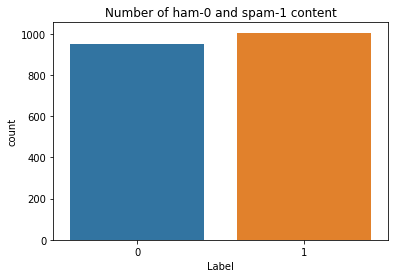

In [ ]:
sns.countplot(df.CLASS)
plt.xlabel('Label')
plt.title('Number of ham-0 and spam-1 content')

In [ ]:
X = df.CONTENT # input 
Y = df.CLASS # output

In [ ]:
# Nếu là 'V1' thì
# Y = df.V1
# le = LabelEncoder()
# Y = le.fit_transform(Y)
# Y = Y.reshape(-1,1)

In [ ]:
 X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

## Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [1]:
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words) 
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train) # 3 => 3 word IDs, 5 => 5 wordIDs
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_SEQUENCE 
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len) # 100 => T

NameError: ignored

In [ ]:
 print(sequences[:2])

In [ ]:
sequences_matrix[:2]

## RNN

In [2]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
def RNN():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words, 50, input_length=max_len)(inputs) 
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [3]:
# model = RNN()
model = Sequential() 
model.add(Embedding(max_words, 50)) 
model.add(LSTM(64))
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1, activation='sigmoid'))

NameError: ignored

In [ ]:
# model = RNN()
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [ ]:
model.summary()

## Tính tham số:
* embedding layer = inputs x outputs = 1000 x 50 = 50000
* lstm layer = [(num_units + input_dim +1) x num_units] x 4 = (64+50+1)*64*4 = 29440
* dense layer = 64*256+256=16640
* dropout = 0
* dense output layer = 256 * 1 +1 = 257

In [ ]:
 from tensorflow.keras.utils import plot_model 
 from IPython.display import Image

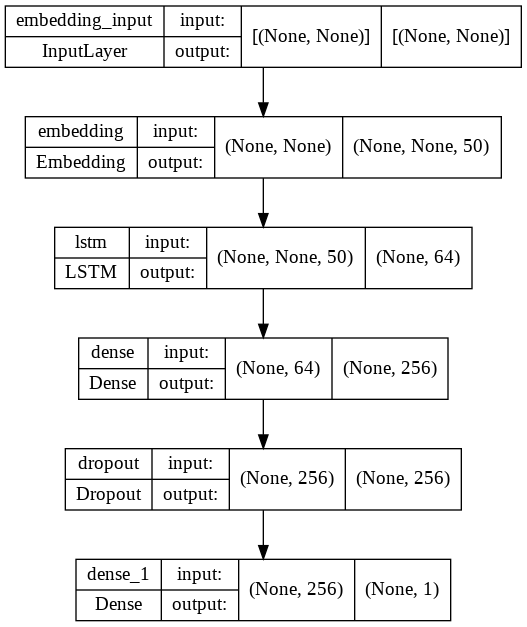

In [ ]:
plot_model(model, to_file='LSTM_model.png', show_shapes=True) 
Image(filename='LSTM_model.png')

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(sequences_matrix,Y_train, # train 
                    batch_size=128,
                    epochs=50,
                    validation_split=0.2, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
9/9 [==============================] - 3s 145ms/step - loss: 0.6737 - accuracy: 0.6329 - val_loss: 0.6174 - val_accuracy: 0.7555
Epoch 2/50
9/9 [==============================] - 1s 92ms/step - loss: 0.5433 - accuracy: 0.7918 - val_loss: 0.4230 - val_accuracy: 0.8431
Epoch 3/50
9/9 [==============================] - 1s 91ms/step - loss: 0.3534 - accuracy: 0.8767 - val_loss: 0.3045 - val_accuracy: 0.8759
Epoch 4/50
9/9 [==============================] - 1s 92ms/step - loss: 0.2097 - accuracy: 0.9416 - val_loss: 0.2084 - val_accuracy: 0.9051
Epoch 5/50
9/9 [==============================] - 1s 93ms/step - loss: 0.1508 - accuracy: 0.9516 - val_loss: 0.1717 - val_accuracy: 0.9343
Epoch 6/50
9/9 [==============================] - 1s 90ms/step - loss: 0.1053 - accuracy: 0.9671 - val_loss: 0.2886 - val_accuracy: 0.9051
Epoch 7/50
9/9 [==============================] - 1s 92ms/step - loss: 0.0938 - accuracy: 0.9735 - val_loss: 0.2084 - val_accuracy: 0.9161
Epoch 8/50
9/9 [==========

In [ ]:
# test
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

19/19 [==============================] - 0s 11ms/step - loss: 0.3056 - accuracy: 0.9216


In [ ]:
 print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.306
  Accuracy: 0.922


In [ ]:
#Save the result
from tensorflow.keras.models import load_model 
# Creates a HDF5 file 'my_model.h5' 
model.save('LSTM_spam_model.h5')

## Make new predictions

In [ ]:
 type(X_test)

pandas.core.series.Series

In [ ]:
X_new = pd.Series(data = ["Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt, please leave a like comment and please sub",
                         "Why dafuq is a Korean song so big in the USA. Does that mean we support Koreans? Last time I checked they wanted to bomb us."])
test_sequences_new = tok.texts_to_sequences(X_new)
test_sequences_matrix_new = sequence.pad_sequences(test_sequences_new,maxlen=max_len)

In [ ]:
X_new

0    Hey guys check out my new channel and our firs...
1    Why dafuq is a Korean song so big in the USA. ...
dtype: object

In [ ]:
test_sequences_matrix_new

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  60,  40,  10,   8,   9,  49,  30,
          5,  82, 215, 651,   3,  15, 176,   4, 141,   4,  27,   4, 788,
        807,  22, 261,   6,  24,  75,   5,  22, 213],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
model.predict(test_sequences_matrix_new)

array([[1.        ],
       [0.00106886]], dtype=float32)